In [3]:
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import math

In [89]:
# load datasets
full_df = pd.read_csv('../datasets/joined_complete_info.csv')

In [90]:
full_df = full_df.rename(columns={'User-ID':'user_id','Book-Rating': 'rating'})

In [130]:
# read in recommendations from json file
# file_path = "collaborative_filtering_recommendations_k_50_users_100.json"
# file_path = "item_based_collaborative_filtering_recommendations_k_50_items_50.json"
# file_path = "filtered_random_walk.json"
# file_path = "page_rank.json"
file_path = "../results/content_based_filtering_recommendations.json"
# file_path = "../results/llama_recommendations.json"
with open(file_path) as json_file:
  recommendations_dict = json.load(json_file)
  recommendations_dict = {
      key: [item.lower() for item in value]
      for key, value in recommendations_dict.items()
  }
  print("data type:", type(recommendations_dict))

data type: <class 'dict'>


In [131]:
def get_item_user_counts(df):
  """
  returns dict mapping books to how many users interacted with it
  """
  item_user_counts = df.groupby("join_title")["user_id"].nunique().to_dict()
  return item_user_counts

In [132]:
def popularity_score(item_user_counts, total_users):

  counts = np.array(list(item_user_counts.values()), dtype=float)
  phi = counts / total_users

  # sort ascending
  phi_sorted = np.sort(phi)

  return phi_sorted


In [133]:
def calculate_gini_coeff(phi_sorted):
  n = len(phi_sorted)
  if n == 0:
    return 0
  # G = sum (2i - n - 1) * phi_i / (n * sum(phi_i)) from i=1 to n
  numerator = np.sum([(2*(i+1) - n - 1) * phi_sorted[i] for i in range(n)])
  denominator = n * np.sum(phi_sorted)
  return numerator / denominator

In [135]:
def compute_gap(popularity_dict, recommendations_dict, num_users):
  avg_user_popularity = 0
  user_ct = 0
  for _, book_recs in recommendations_dict.items():
    if len(book_recs) == 0:
      continue

    total_popularity = 0
    for book in book_recs:
      if book.lower() in popularity_dict:
        total_popularity += (popularity_dict[book.lower()] / num_users)

    avg_user_popularity += (total_popularity / len(book_recs))
    user_ct += 1

  return avg_user_popularity / user_ct

In [136]:
def compute_novelty(popularity_score):
  return -1 * math.log(popularity_score)

In [137]:
import matplotlib.pyplot as plt

def get_author_demographic_pie_chart(recommendations_df, full_df, author_to_country, title):
    """
    Pie chart of author demographics:
    - Top 9 nationalities shown
    - Remaining grouped as 'Other'
    """

    full_unique = (
        full_df[['join_title', 'Book-Author']]
        .drop_duplicates(subset='join_title', keep='first')
    )


    merged_df = recommendations_df.merge(
        full_unique[['join_title', 'Book-Author']],
        on='join_title',
        how='left'
    )

    merged_df['Book-Author'] = merged_df['Book-Author'].str.lower()
    merged_df['Nationality'] = merged_df['Book-Author'].map(author_to_country)

    print(merged_df.head())

    counts = merged_df['Nationality'].value_counts()
    print(counts)

    top_9 = counts.head(9)
    other = counts.iloc[9:].sum()
    if other > 0:
        top_9.loc['Other'] = other

    nat_counts = top_9.values
    nat_labels = top_9.index

    # ---- Plot ----
    plt.figure(figsize=(8, 8))
    plt.pie(
        nat_counts,
        startangle=90,
        counterclock=False,
        autopct=None,  
        labels=None       
    )

    plt.legend(
        nat_labels,
        title="Nationalities",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=12,        
        title_fontsize=14  
    )

    plt.title(title)
    plt.tight_layout()
    plt.show()



In [138]:
# process recommendations data to be able to compute popularity scores and gini coeff
recommendations = []
for user_id, user_recs in recommendations_dict.items():
  for book in user_recs:
    recommendations.append({"user_id": user_id, "join_title": book})

recs_df = pd.DataFrame(recommendations)


In [139]:
print(recs_df.head())

  user_id                                         join_title
0      26                                  follow your heart
1      26                              an american childhood
2      26                                        three tales
3      26  savage inequalities: children in america's sch...
4      26                    journey to the end of the night


In [140]:
# gini coeff for recommendations
rec_item_user_counts = get_item_user_counts(recs_df)
num_rec_users = len(recommendations_dict)
rec_pop_scores = popularity_score(rec_item_user_counts, num_rec_users)
rec_gini_coeff = calculate_gini_coeff(rec_pop_scores)
print(f"Recommendations gini coeff: {rec_gini_coeff}")

Recommendations gini coeff: 0.38451673287316684


In [141]:
print(rec_item_user_counts)

{"'salem's lot": 246, '10 lb penalty': 154, '1421: the year china discovered america': 455, '1984': 249, '3rd degree': 605, 'a bend in the river': 178, 'a bend in the road': 531, 'a break with charity: a story about the salem witch trials': 284, 'a brief history of time': 488, 'a briefer history of time': 275, 'a caribbean mystery': 104, "a child's garden of verses": 233, 'a christmas carol': 241, 'a christmas memory': 334, 'a civil action': 218, 'a clockwork orange': 303, 'a confederacy of dunces': 216, 'a damsel in distress': 67, 'a dangerous fortune': 500, 'a different mirror: a history of multicultural america': 337, 'a distant mirror: the calamitous 14th century': 357, 'a fairly honourable defeat': 69, 'a farewell to arms': 167, 'a fine balance': 330, 'a friend of the earth': 364, 'a frolic of his own': 709, 'a god in ruins': 175, 'a heartbreaking work of staggering genius': 385, 'a home at the end of the world': 257, 'a kiss before dying': 659, 'a lesson before dying': 257, 'a li

In [142]:
# gini coeff for full dataset
full_item_user_counts = get_item_user_counts(full_df)
full_users = list(set(full_df.user_id.unique()))
total_num_users = len(full_users)
full_pop_scores = popularity_score(full_item_user_counts, total_num_users)
full_gini_coeff = calculate_gini_coeff(full_pop_scores)
print(f"Full dataset gini coeff: {full_gini_coeff}")

Full dataset gini coeff: 0.7085942099551412


In [143]:
gap_score = compute_gap(full_item_user_counts, recommendations_dict, total_num_users)
novelty_score = compute_novelty(gap_score)
print(f"GAP score: {gap_score}, novelty score: {novelty_score}")

GAP score: 0.002737257614658474, novelty score: 5.900798730350156


In [144]:
with open("../datasets/author_countries.json", "r") as file:
    author_to_country = json.load(file)
author_to_country = {key.lower(): value for key, value in author_to_country.items()}

In [145]:
recs_df

,user_id,join_title
0,26,follow your heart
1,26,an american childhood
2,26,three tales
3,26,savage inequalities: children in america's sch...
4,26,journey to the end of the night
...,...,...
502745,278846,maya
502746,278846,the war of the worlds
502747,278846,the outsiders
502748,278846,the master and margarita


  user_id                                         join_title  \
0      26                                  follow your heart   
1      26                              an american childhood   
2      26                                        three tales   
3      26  savage inequalities: children in america's sch...   
4      26                    journey to the end of the night   

              Book-Author Nationality  
0          susanna tamaro     italian  
1           annie dillard         NaN  
2        gustave flaubert      french  
3          jonathan kozol    american  
4  louis-ferdinand celine      french  
Nationality
american            266719
british              56407
unknown              17481
canadian             10748
english               9275
                     ...  
uruguayan               95
ancient chinese         79
haitian-american        69
indian-american         52
bangladeshi             32
Name: count, Length: 86, dtype: int64


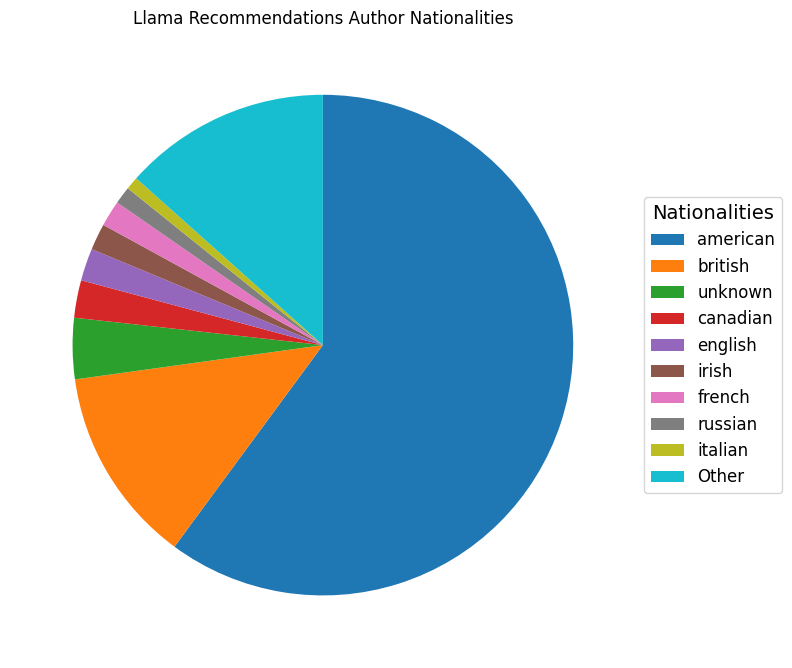

In [146]:
get_author_demographic_pie_chart(recs_df, full_df, author_to_country, "Llama Recommendations Author Nationalities")

In [147]:
# Count how many unique books were recommended
unique_recommended_books = recs_df['join_title'].nunique()
print("Number of unique recommended books:", unique_recommended_books)

# All distinct books in the dataset
unique_full_books = full_df['join_title'].nunique()
print("Total unique books in dataset:", unique_full_books)

recommended_set = set(recs_df['join_title'].unique())
full_set = set(full_df['join_title'].unique())

never_recommended = full_set - recommended_set
print("Number of books never recommended:", len(never_recommended))
print("Percent of books never recommended:", len(never_recommended) / len(full_set))

# look at genres
full_df['genre_list'] = full_df['genres'].str.split('|')
print(full_df['genre_list'].head())

book_to_genres = (full_df.groupby("join_title")["genres"].first().apply(lambda x: x.split("|") if x else []).to_dict())
print(book_to_genres)
print(len(book_to_genres))

recs_df["genre_list"] = recs_df["join_title"].map(book_to_genres)
print(recs_df.head())

recs_exploded = recs_df.explode("genre_list")
print(recs_exploded.head(10))

full_exploded = full_df.explode("genre_list")
print(full_exploded.head(10))

rec_genre_counts = recs_exploded["genre_list"].value_counts()
full_genre_counts = full_exploded["genre_list"].value_counts()
rec_genre_percent = rec_genre_counts / rec_genre_counts.sum()
full_genre_percent = full_genre_counts / full_genre_counts.sum()

top_genres = 10
full_top_genres = full_genre_percent.head(top_genres)
rec_top_genres = rec_genre_percent.head(top_genres)

Number of unique recommended books: 1562
Total unique books in dataset: 1575
Number of books never recommended: 13
Percent of books never recommended: 0.008253968253968255
0                                   [Fiction, Mystery]
1    [Horror, Fiction, Thriller, Science Fiction, S...
2                          [Horror, Fiction, Thriller]
3       [Classics, Fiction, Cultural, Russia, Romance]
4    [Fiction, Classics, Horror, Fantasy, Literatur...
Name: genre_list, dtype: object
{"'salem's lot": ['Horror', 'Fiction', 'Paranormal', 'Vampires', 'Fantasy'], '10 lb penalty': ['Mystery', 'Fiction', 'Mystery', 'Crime', 'Thriller'], '1421: the year china discovered america': ['History', 'Nonfiction', 'Cultural', 'China', 'Cultural', 'Asia', 'Historical'], '1984': ['Classics', 'Fiction', 'Science Fiction', 'Science Fiction', 'Dystopia'], '3rd degree': ['Mystery', 'Fiction', 'Mystery', 'Crime', 'Thriller'], 'a bend in the river': ['Cultural', 'Africa', 'Classics', 'Literature', 'Novels'], 'a bend in

In [148]:
rec_top_genres

genre_list
Fiction               0.134609
Classics              0.055919
Historical            0.051487
Literature            0.047319
Fantasy               0.036916
Historical Fiction    0.036520
Romance               0.029861
Cultural              0.029228
Mystery               0.029074
Nonfiction            0.025435
Name: count, dtype: float64

In [149]:
full_top_genres

genre_list
Fiction               0.156013
Mystery               0.057367
Thriller              0.055893
Historical            0.052114
Classics              0.048954
Historical Fiction    0.037245
Fantasy               0.035359
Romance               0.031737
Literature            0.031607
Contemporary          0.030890
Name: count, dtype: float64

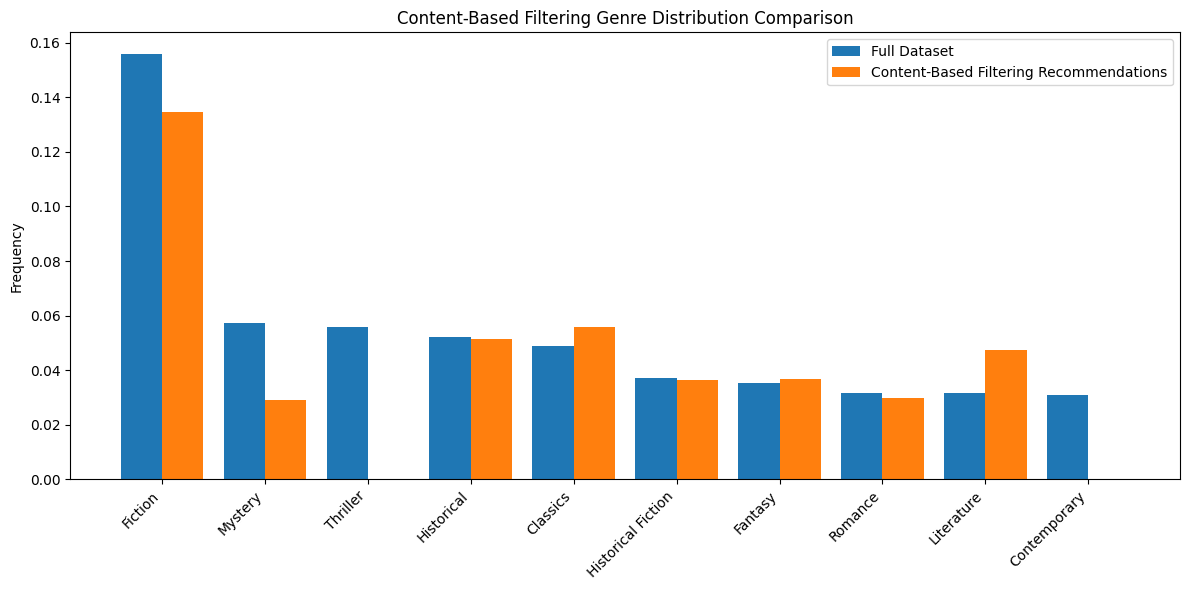

In [150]:
rec_impl = "Content-Based Filtering"
genres = full_top_genres.index
x = np.arange(len(genres))
rec_aligned = rec_top_genres.reindex(genres, fill_value=0)


plt.figure(figsize=(12,6))
plt.bar(x - 0.2, full_top_genres.values, width=0.4, label="Full Dataset")
plt.bar(x + 0.2, rec_aligned.values, width=0.4, label=f"{rec_impl} Recommendations")

plt.xticks(x, genres, rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title(f"{rec_impl} Genre Distribution Comparison")
plt.legend()
plt.tight_layout()
plt.show()